In [4]:
import importlib
import src.utils

importlib.reload(src.utils)

<module 'src.utils' from 'C:\\Users\\lovas\\Desktop\\Market_risk_prediction\\src\\utils.py'>

In [16]:
import pandas as pd
from joblib import dump, load

import sys
from pathlib import Path

# Add project root to sys.path
project_root = Path().resolve().parent # assumes notebook is in a subdirectory of the project root
sys.path.append(str(project_root))

from src.utils import best_threshold, train_test_by_time
from src.MyPlotting import plot_pr_curve, plot_permutation_importance
from src.evaluation import give_metrics


In [2]:
shallow_rf = load(project_root / 'results/models/shallow_rf.joblib')
deep_rf = load(project_root / 'results/models/deep_rf.joblib')
xgb = load(project_root / 'results/models/xgb.joblib')

In [10]:
normalized_features = ['Vol20/VIX', 'Vol5/VIX', 'Scaled_Lag_1d', 'Scaled_Lag_3d',
                       'Sharpe-like_10', 'Sharpe-like_5', 'log_returns_zscore' ,'VIX_zscore']

normalized_features += ['Momentum5_20', 'Momentum10_20', 'Momentum5_10', 'Momentum3_20', 'Momentum3_10', 'Momentum3_5'] # 5_20 is the original
normalized_features += ['Scaled_weighted_avg']

In [18]:
sp500 = pd.read_csv(project_root / "data/processed/sp500_processed.csv", index_col=0, parse_dates=True)
nasdaq = pd.read_csv(project_root / "data/processed/nasdaq_processed.csv", index_col=0, parse_dates=True)
dax = pd.read_csv(project_root / "data/processed/dax_processed.csv", index_col=0, parse_dates=True)

_, X_sp500, _,  y_sp500 = train_test_by_time(sp500)
_, X_nasdaq, _,  y_nasdaq = train_test_by_time(nasdaq)
_, X_dax, _,  y_dax = train_test_by_time(dax)

markets = {'SP500': (X_sp500, y_sp500),
           'Nasdaq': (X_nasdaq, y_nasdaq),
           'DAX': (X_dax, y_dax)}

In [33]:
proba_dict = {}
pred_dict = {}

for model, name in [(shallow_rf, 'Shallow RF'), (deep_rf, 'Deep RF'), (xgb, 'XGB')]:
    for market, (X_test, y_test) in markets.items():
        X_test = X_test[normalized_features]
        proba_dict[(market, name)] = model.predict_proba(X_test)[:, 1]
        pred_dict[(market, name)] = proba_dict[(market, name)] > best_threshold(y_test, proba_dict[(market, name)])

0.47999999999999976
0.5299999999999998
0.5649999999999998
0.42999999999999977
0.47499999999999976
0.47999999999999976
0.6749999999999997
0.6699999999999997
0.6249999999999998


In [34]:
metrics = pd.DataFrame()
for (market, name) in proba_dict:
    y_test = markets[market][1]
    metrics = give_metrics(y_test, pred_dict[(market,name)], proba_dict[(market, name)], df=metrics, model_name=f"{market} - {name}")

In [36]:
metrics

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Average Precision
SP500 - Shallow RF,0.776016,0.137931,0.551724,0.220690,0.741651,0.132633
Nasdaq - Shallow RF,0.758176,0.192623,0.500000,0.278107,0.715487,0.169579
DAX - Shallow RF,0.841691,0.142857,0.375000,0.206897,0.679593,0.115396
SP500 - Deep RF,0.826561,0.161850,0.482759,0.242424,0.750571,0.147282
Nasdaq - Deep RF,0.789891,0.205000,0.436170,0.278912,0.707185,0.164503
DAX - Deep RF,0.857424,0.160305,0.375000,0.224599,0.685019,0.124821
SP500 - XGB,0.908821,0.242424,0.275862,0.258065,0.703932,0.157878
Nasdaq - XGB,0.857284,0.259615,0.287234,0.272727,0.646809,0.158618
DAX - XGB,0.893805,0.157895,0.214286,0.181818,0.641157,0.091552


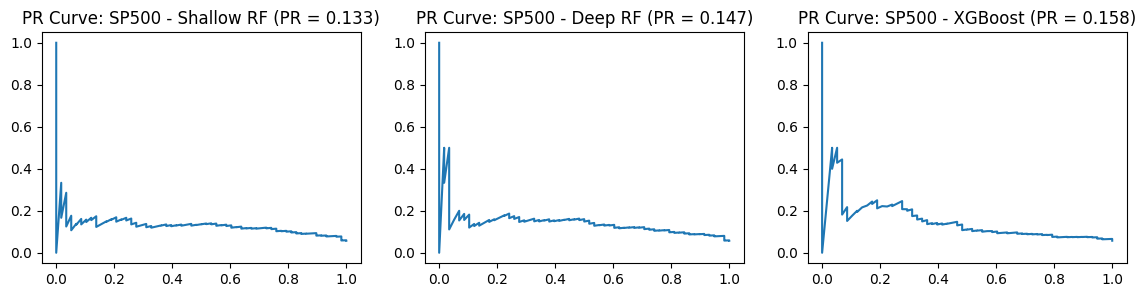

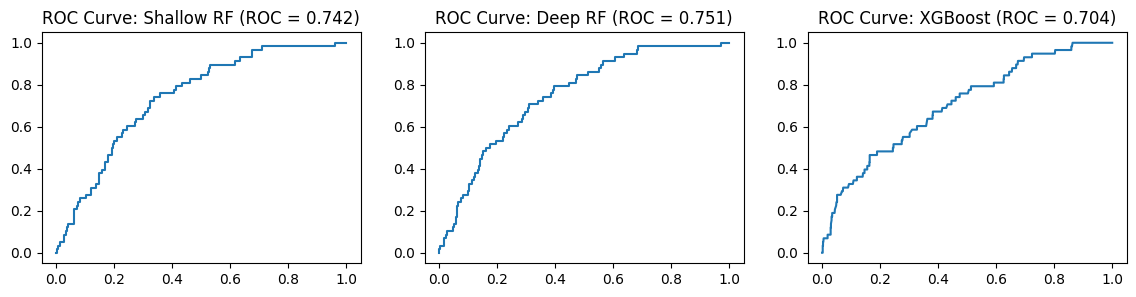

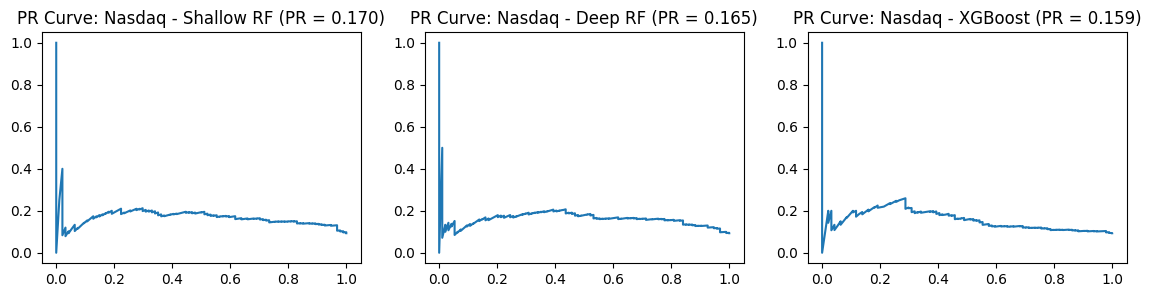

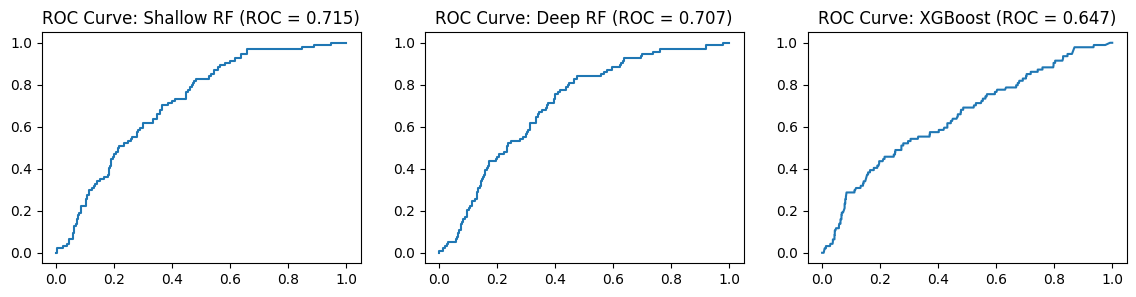

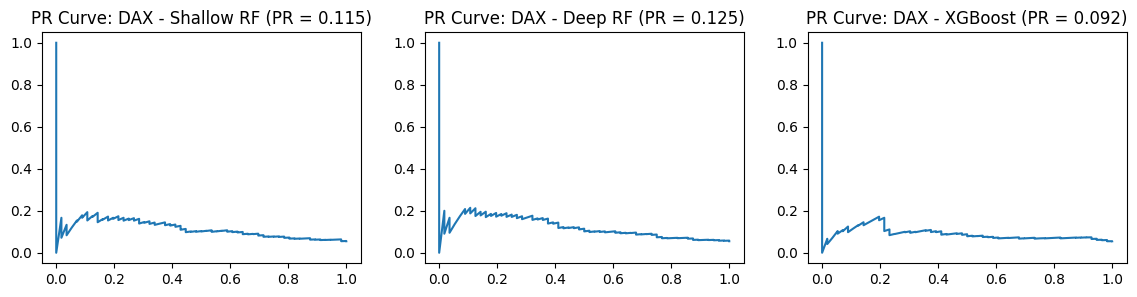

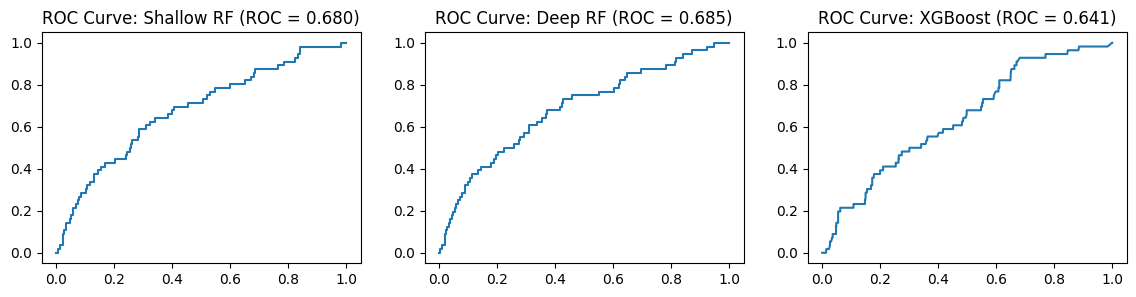

In [39]:
for market, (X_test, y_test) in markets.items():
    X_test = X_test[normalized_features]
    plot_pr_curve(y_test, X_test, [shallow_rf, deep_rf, xgb],
                model_names=[f'{market} - Shallow RF', 
                            f'{market} - Deep RF',
                            f'{market} - XGBoost'])
    plot_pr_curve(y_test, X_test, [shallow_rf, deep_rf, xgb],
                model_names=['Shallow RF', 'Deep RF', 'XGBoost'], curve_type='ROC')
    # making them on a single plot might be nice

Permutation Importance for SP500


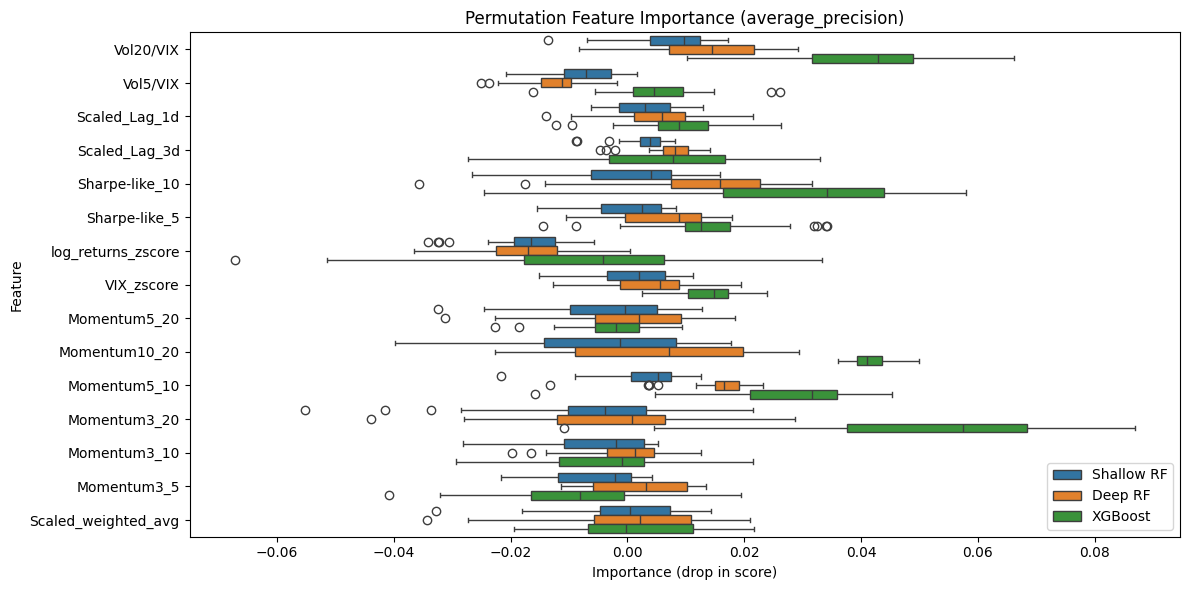

Permutation Importance for Nasdaq


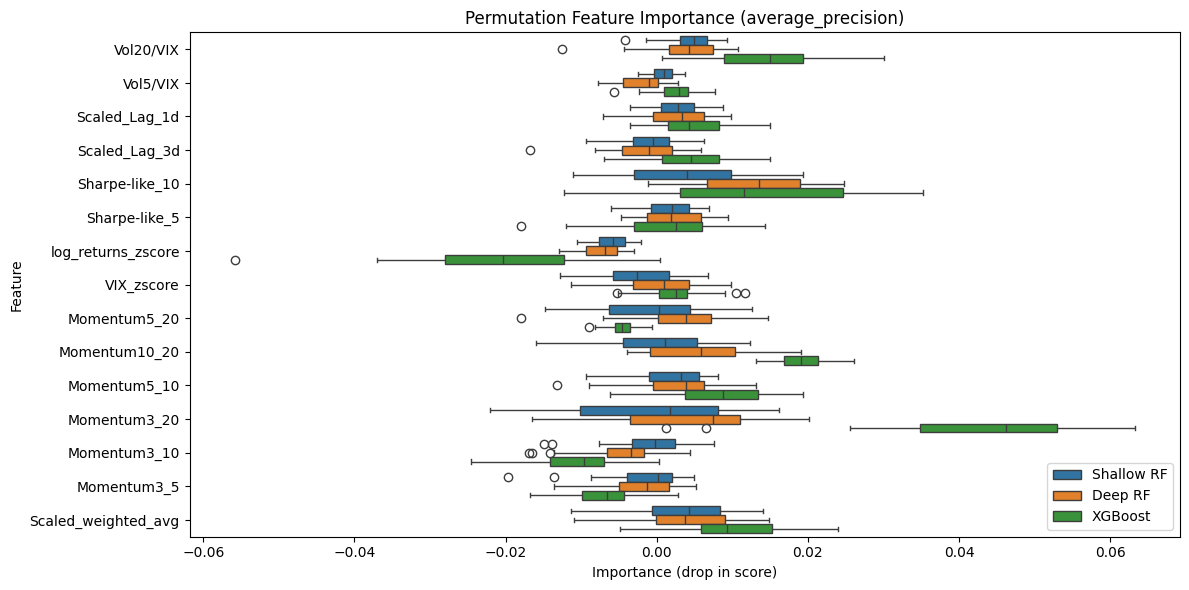

Permutation Importance for DAX


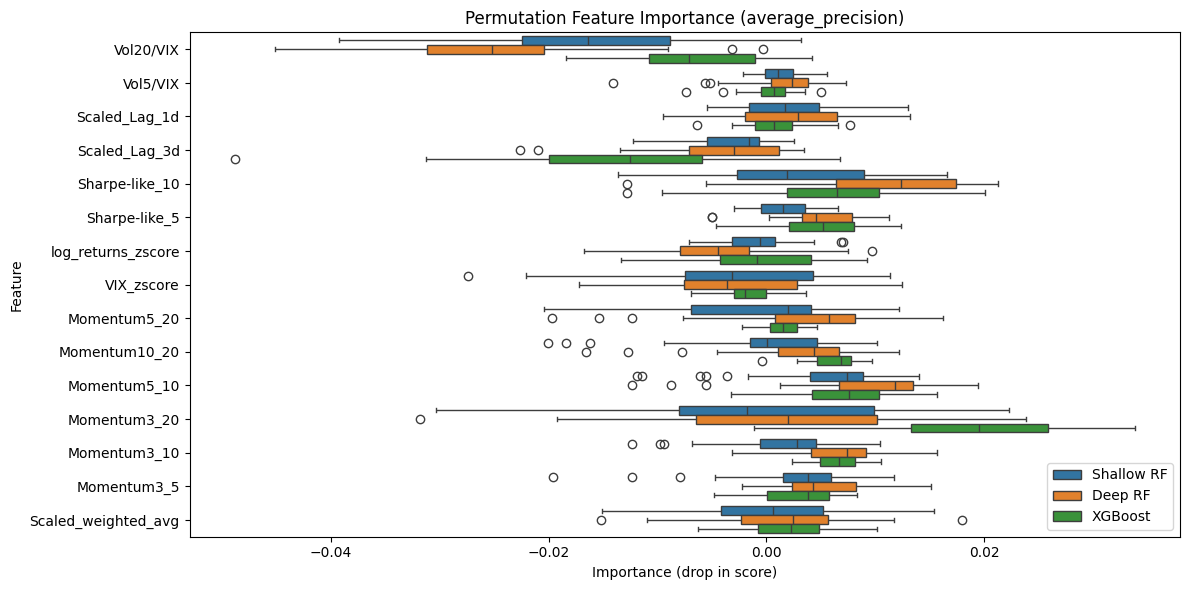

In [44]:
for market, (X_test, y_test) in markets.items():
    print(f"Permutation Importance for {market}")
    plot_permutation_importance( [shallow_rf, deep_rf, xgb], 
                            X_test[normalized_features], y_test,
                            model_names=['Shallow RF', 'Deep RF', 'XGBoost'], 
                            scoring='average_precision')